### Abrir archivo features


In [47]:
import numpy as np
import pandas as pd
df = pd.read_csv('./video_features-master/train_s3d_15_mean.csv') #cambiar la ruta a tu archivo
train_subset = pd.read_csv('./video_features-master/train_subset.csv') #para sacar las etiquetas de los x primeras filas
X = df.to_numpy()
#etiquetas 
y = train_subset['label'].to_numpy()
y = y[:X.shape[0]]


print("dimensiones: " , X.shape)
print("etiquetas: " , y.shape)

dimensiones:  (15, 1025)
etiquetas:  (15,)


De esos miles de features queremos capturar apenas los más relevantes, aplicamos librerias para reducir la dimensionalidad. Cuando aplicamos algoritmos de reducción queremos capturar la mayor varianza posible (ya que más varianza = más información), capturando los features más relevantes



### Función para graficar

In [36]:
import matplotlib.pyplot as plt
def graph_variances(explained_variance_ratio):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
    plt.xlabel('Component number')
    plt.ylabel('Explained variance ratio')
    plt.title('Explained Variance Ratio per Component')

flatten (no se si es viable por la cantidad de filas)

In [3]:
X_flat = X.flatten()
X_flat = X_flat.reshape(-1,1)
print("dimensiones: " , X_flat.shape)	

dimensiones:  (15375, 1)


### PCA

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15) #probar distintos valores
X_pca = pca.fit_transform(X)
print("Reduced dimensions shape: ", X_pca.shape)

Reduced dimensions shape:  (15, 15)


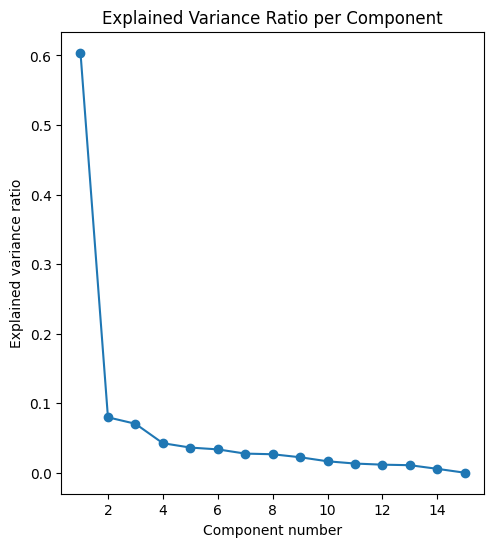

In [38]:
graph_variances(pca.explained_variance_ratio_)

### Truncated SVD

In [6]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np
np.random.seed(0)
#X_dense = np.random.rand(100, 100)
#X_dense[:, 2 * np.arange(50)] = 0
#X = csr_matrix(X_dense)
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42) #cambiar numero de componentes
X_svd =svd.fit_transform(X)
TruncatedSVD(n_components=5, n_iter=7, random_state=42)
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

[0.5602586  0.07876169 0.07684181 0.05041292 0.04243787]
0.8087128877861327
[32.61730549  6.44729603  6.14396458  5.1908847   4.53227157]


In [10]:
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_explained_variance >= 0.90) + 1

print(f'Optimal number of components: {optimal_components}')
print(cumulative_explained_variance)
print(X_svd.shape)

Optimal number of components: 1
[0.5602586  0.63902029 0.7158621  0.76627501 0.80871289]
(15, 5)


### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
#y = np.array([1, 1, 1, 2, 2, 2])
clf = LinearDiscriminantAnalysis()
X_lda = clf.fit_transform(X, y)
LinearDiscriminantAnalysis()
print(clf.predict([[-0.8, -1]]))

### Gaussian Random projection


In [ ]:
from sklearn import random_projection
transformer = random_projection.GaussianRandomProjection()
X_gaussian = transformer.fit_transform(X)
X_gaussian.shape

### Factor Analysis

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FactorAnalysis
X, _ = load_digits(return_X_y=True)
transformer = FactorAnalysis(n_components=7, random_state=0)
X_fa = transformer.fit_transform(X)
X_fa.shape

### Accuracy testing
Probando clustering con libreria solo para ver accuracy

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

#transform labels from text to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply K-means clustering
n_clusters = len(np.unique(y_encoded))  # Set number of clusters to number of unique labels
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca) #CAMBIAR ESTO POR EL X REDUCIDO QUE QUEREMOS PROBAR

# Map cluster labels to true labels
def map_labels(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in range(n_clusters):
        mask = (y_pred == i)
        if np.sum(mask) > 0:
            labels[mask] = mode(y_true[mask])[0]
    return labels

# Map predicted labels to true labels
y_kmeans_mapped = map_labels(y_encoded, y_kmeans)

# Calculate accuracy
accuracy = accuracy_score(y_encoded, y_kmeans_mapped)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.67
